In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval

## Setup
In this notebook, we will run SfM reconstruction from scratch on a set of images. We choose the [South-Building dataset](https://openaccess.thecvf.com/content_cvpr_2013/html/Hane_Joint_3D_Scene_2013_CVPR_paper.html) - we will download it later. First, we define some paths.

In [3]:
images = Path('datasets/South-Building/images/')

outputs = Path('outputs/sfm/')
sfm_pairs = outputs / 'pairs-megaloc.txt'
sfm_dir = outputs / 'sfm_superpoint+lightglue'

retrieval_conf = extract_features.confs['megaloc']
feature_conf = extract_features.confs['superpoint_max']


# outputs = Path('outputs/sfm/')
# sfm_pairs = outputs / 'pairs-netvlad.txt'
# sfm_dir = outputs / 'sfm_superpoint+superglue'

# retrieval_conf = extract_features.confs['netvlad']
# feature_conf = extract_features.confs['roma']


In [2]:
matcher_conf = match_features.confs['lightglue_gim']

## Download the dataset
The dataset is simply a set of images. The intrinsic parameters will be extracted from the EXIF data and refined with SfM.

In [4]:
if not images.exists():
    !wget http://cvg.ethz.ch/research/local-feature-evaluation/South-Building.zip -P datasets/
    !unzip -q datasets/South-Building.zip -d datasets/

## Find image pairs via image retrieval
We extract global descriptors with NetVLAD and find for each image the most similar ones. For smaller dataset we can instead use exhaustive matching via `hloc/pairs_from_exhaustive.py`, which would find $\frac{n(n-1)}{2}$ images pairs.

In [4]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs) # computes and stores global descriptors of all images
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=2) # finds pairs of images to be matched

[2025/10/18 15:39:49 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'megaloc'},
 'output': 'global-feats-megaloc',
 'preprocessing': {'resize_max': 1024}}
[2025/10/18 15:39:49 hloc INFO] Found 7 images in root datasets/South-Building/images.


[2025/10/18 15:39:49 hloc INFO] Skipping the extraction.
[2025/10/18 15:39:49 hloc INFO] Extracting image pairs from a retrieval database.
[2025/10/18 15:39:50 hloc INFO] Found 14 pairs.


## Extract and match local features

In [5]:
retrieval_path

PosixPath('outputs/sfm/global-feats-megaloc.h5')

In [15]:
# %pip install einops kornia albumentations loguru tqdm matplotlib h5py wandb timm poselib fused-local-corr>=0.2.2


In [6]:
feature_path = extract_features.main(feature_conf, images, outputs)


[2025/10/18 15:40:10 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}
[2025/10/18 15:40:10 hloc INFO] Found 7 images in root datasets/South-Building/images.


Loaded SuperPoint model


  0%|          | 0/7 [00:00<?, ?it/s]/home/vuthanhdat/anaconda3/envs/croco/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 7/7 [00:27<00:00,  3.90s/it]
[2025/10/18 15:40:37 hloc INFO] Finished exporting features.


In [7]:
outputs

PosixPath('outputs/sfm')

In [7]:
feature_conf['output']

'feats-superpoint-n4096-rmax1600'

In [7]:
matcher_conf

{'output': 'matches-lightglue_gim', 'model': {'name': 'lightglue_gim'}}

- light glue gim:
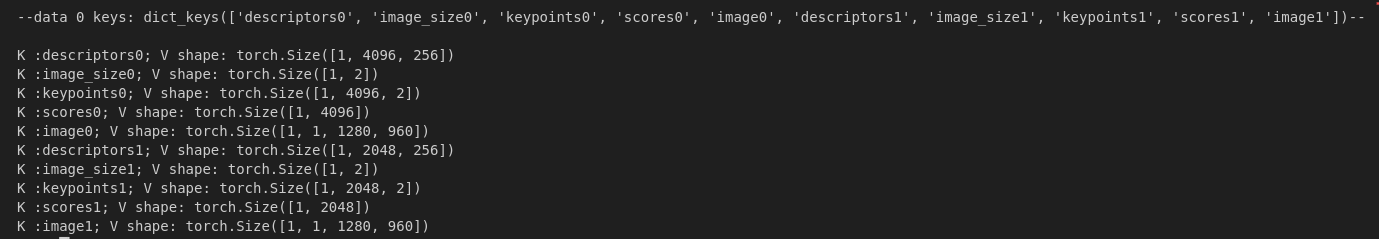

- light glue:
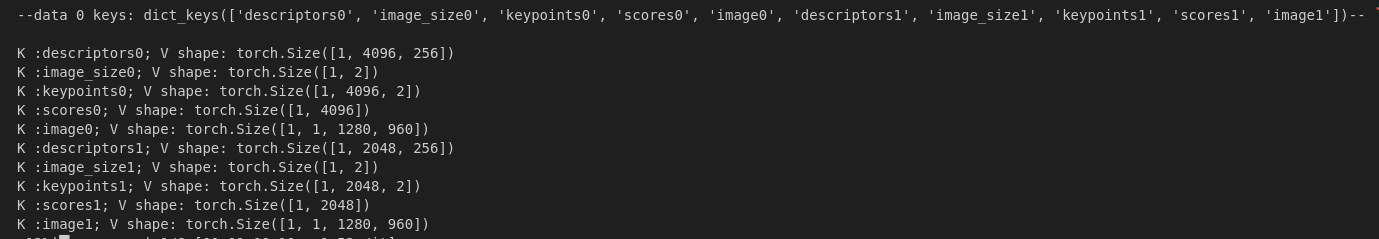

shape of image in 2 model is same
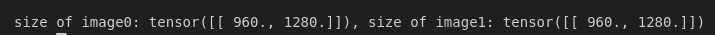

In [8]:
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2025/10/18 15:41:01 hloc INFO] Matching local features with configuration:
{'model': {'name': 'lightglue_gim'}, 'output': 'matches-lightglue_gim'}


Loaded LightGlueGim checkpoint from: /home/vuthanhdat/VisualLocalization/crocodl-benchmark/external/hloc/third_party/SuperGluePretrainedNetwork/models/weights/gim_lightglue_100h.ckpt


/home/vuthanhdat/VisualLocalization/crocodl-benchmark/external/hloc/hloc/extractors/../../third_party/SuperGluePretrainedNetwork/models/lightglue.py:21: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
  0%|          | 0/8 [00:00<?, ?it/s]


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 12%|█▎        | 1/8 [00:09<01:05,  9.38s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (4096,)----

Datasets in group: ['matches0']

-----shape scores: (4096,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 25%|██▌       | 2/8 [00:16<00:50,  8.34s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (2353,)----

Datasets in group: ['matches0']

-----shape scores: (2353,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 38%|███▊      | 3/8 [00:21<00:35,  7.15s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (2353,)----

Datasets in group: ['matches0']

-----shape scores: (2353,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 50%|█████     | 4/8 [00:30<00:30,  7.53s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (4096,)----

Datasets in group: ['matches0']

-----shape scores: (4096,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 62%|██████▎   | 5/8 [00:39<00:23,  7.85s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (2887,)----

Datasets in group: ['matches0']

-----shape scores: (2887,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 75%|███████▌  | 6/8 [00:59<00:20, 10.41s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (4096,)----

Datasets in group: ['matches0']

-----shape scores: (4096,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



 88%|████████▊ | 7/8 [01:05<00:09,  9.72s/it]


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (2231,)----

Datasets in group: ['matches0']

-----shape scores: (2231,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---



100%|██████████| 8/8 [01:12<00:00,  9.07s/it]
[2025/10/18 15:42:14 hloc INFO] Finished exporting matches.



------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (3039,)----

Datasets in group: ['matches0']

-----shape scores: (3039,)----

Datasets in group: ['matches0', 'matching_scores0']


## 3D reconstruction
Run COLMAP on the features and matches.

In [9]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path)

[2025/10/18 15:42:19 hloc INFO] Creating an empty database...
[2025/10/18 15:42:19 hloc INFO] Importing images into the database...
[2025/10/18 15:42:19 hloc INFO] Importing features into the database...
100%|██████████| 7/7 [00:00<00:00, 549.19it/s]
[2025/10/18 15:42:19 hloc INFO] Importing matches into the database...
100%|██████████| 14/14 [00:00<00:00, 1447.49it/s]
[2025/10/18 15:42:19 hloc INFO] Performing geometric verification of the matches...
I20251018 15:42:19.753241 130943597672128 misc.cc:44] 
Feature matching
I20251018 15:42:19.753718 130943255836352 sift.cc:1434] Creating SIFT CPU feature matcher
I20251018 15:42:19.753743 130943343916736 sift.cc:1434] Creating SIFT CPU feature matcher
I20251018 15:42:19.753775 130943211796160 sift.cc:1434] Creating SIFT CPU feature matcher
I20251018 15:42:19.753799 130943476037312 sift.cc:1434] Creating SIFT CPU feature matcher
I20251018 15:42:19.753864 130943520077504 sift.cc:1434] Creating SIFT CPU feature matcher
I20251018 15:42:19.753


 --- model path: outputs/sfm/sfm_superpoint+lightglue/models --- 



I20251018 15:42:20.056263 130944422254080 incremental_pipeline.cc:428] Registering image #2 (num_reg_frames=2)
I20251018 15:42:20.056283 130944422254080 incremental_pipeline.cc:431] => Image sees 486 / 1895 points
I20251018 15:42:20.324954 130944422254080 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20251018 15:42:20.376721 130944422254080 incremental_pipeline.cc:428] Registering image #4 (num_reg_frames=3)
I20251018 15:42:20.376740 130944422254080 incremental_pipeline.cc:431] => Image sees 755 / 1251 points
I20251018 15:42:20.652463 130944422254080 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20251018 15:42:20.717675 130944422254080 incremental_pipeline.cc:584] Keeping successful reconstruction
I20251018 15:42:20.718074 130944422254080 incremental_pipeline.cc:300] Finding good initial image pair
I20251018 15:42:20.738491 130944422254080 incremental_pipeline.cc:324] Registering initial image pair #6 and #5
I20251018 15:42:20.739

## Visualization
We visualize some of the registered images, and color their keypoint by visibility, track length, or triangulated depth.

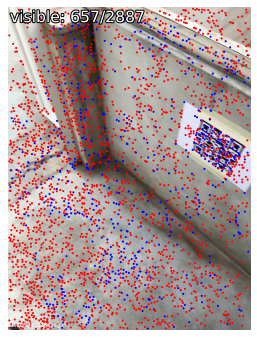

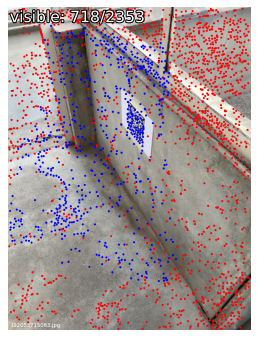

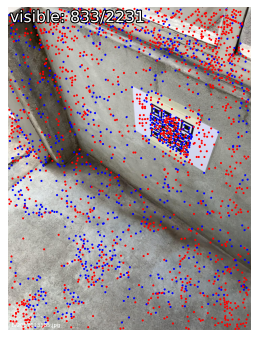

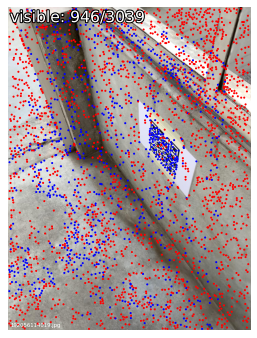

In [10]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

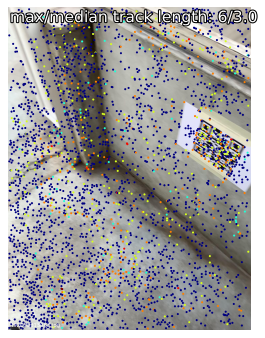

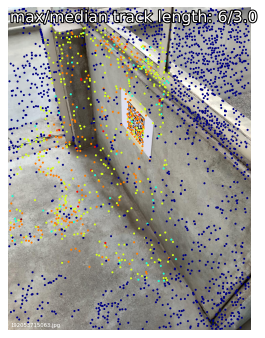

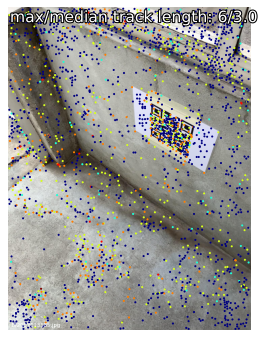

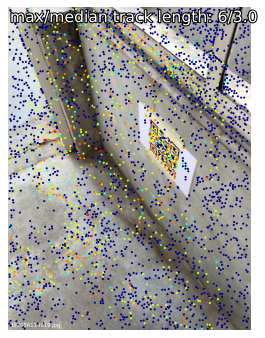

In [11]:
visualization.visualize_sfm_2d(model, images, color_by='track_length', n=5)

In [12]:
visualization.visualize_sfm_2d(model, images, color_by='depth', n=5)

AttributeError: 'pycolmap._core.Image' object has no attribute 'transform_to_image'

In [11]:
import torch
import cv2

In [8]:
file_h5_dir = "/home/vuthanhdat/VisualLocalization/crocodl-benchmark/external/hloc/outputs/sfm/feats-superpoint-n4096-rmax1600_matches-lightglue_gim_pairs-megaloc.h5"
# read h5 file
import h5py
f = h5py.File(file_h5_dir, 'r')
list(f.keys())


['192053715063.jpg',
 '192056114019.jpg',
 '192057113585.jpg',
 '192058313063.jpg',
 '8d04340dc1e04bbe12f1.jpg',
 'd472c60e33e3b9bde0f2.jpg']

In [18]:
f['192053715063.jpg']['192057113585.jpg']['matches0'], f['192053715063.jpg']['192057113585.jpg']['matching_scores0']

(<HDF5 dataset "matches0": shape (2353,), type "<i2">,
 <HDF5 dataset "matching_scores0": shape (2353,), type "<f2">)

In [19]:
f['192057113585.jpg'].keys()

<KeysViewHDF5 ['192056114019.jpg', '192058313063.jpg']>

In [13]:
f_q_pyramid = {
    scale: f_scale.chunk(2)[0] for scale, f_scale in feature_pyramid.items()
}
f_s_pyramid = {
    scale: f_scale.chunk(2)[1] for scale, f_scale in feature_pyramid.items()
}

AttributeError: 'tuple' object has no attribute 'items'